# Covid-19 detection (Positive/Nagetive)

Chest X-ray between normal people and covid19 affected people are totally different . From chest X-ray dataset trying to detect the covid19 diseases

Author : Bishwajit Shil


Department of Physics , Rajshahi

import google-drive for loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### import chest-xray image dataset and agumentaion

In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/drive/MyDrive/datasets/covid19/train/'
validation_dir = '/content/drive/MyDrive/datasets/covid19/val/'

In [4]:
width= 400
height=400
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                  rotation_range = 40,
                                  shear_range = 0.4,
                                  zoom_range = 0.4,
                                  width_shift_range = 0.4,
                                  height_shift_range = 0.4,
                                  horizontal_flip =True,
                                  fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale= 1.0/255)


training_generator = train_datagen.flow_from_directory(train_dir,
                                                      batch_size = 10,
                                                      target_size=(width,height),
                                                      class_mode = 'categorical',
                                                      color_mode = 'rgb',
                                                      shuffle = True      
                                                      )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             batch_size = 10,
                                                             target_size =(width, height),
                                                             color_mode = 'rgb',
                                                            #  shuffle = True ,                                                                
                                                             class_mode = 'categorical')

Found 108 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [52]:
validation_generator.class_indices

{'covid': 0, 'normal': 1}

      few Training Images look like

In [53]:
# import matplotlib.pyplot as plt
# import numpy as np

# for image, label in validation_generator:
#     print(image.shape)
#     for i in range(0,6):
#         plt.subplot(2,3,1+i)
#         plt.imshow(image[i][0],  cmap ='gray')
#         # if label[i] == 0:
#         #     strr ='Covid19'
#         # else:
#         #     strr ='Normal'
            
#         # plt.title(strr)    
#     plt.show()
#     break
    

    #### Import VGG19

In [54]:
from keras.applications import VGG19

VGG19 = VGG19(weights ='imagenet',
             include_top = False,
             input_shape = (width, height, 3))

for i, layer in enumerate(VGG19.layers):
    print(str(i)+' '+layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 Conv2D True
11 MaxPooling2D True
12 Conv2D True
13 Conv2D True
14 Conv2D True
15 Conv2D True
16 MaxPooling2D True
17 Conv2D True
18 Conv2D True
19 Conv2D True
20 Conv2D True
21 MaxPooling2D True


In [55]:
for layer in VGG19.layers:
    layer.trainable = False
    
    
for i,layer in enumerate(VGG19.layers):
    print(str(i)+' '+layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


    Fully connected the top layer of the VGG19 model

In [57]:
import tensorflow as tf
def addTopModel(bottom_model, num_classes, D=2048):
    top_model = bottom_model.output
    top_model = tf.keras.layers.Flatten(name='flatten')(top_model)
    top_model = tf.keras.layers.Dense(D, activation='relu')(top_model)
    top_model = tf.keras.layers.Dense(1024, activation='relu')(top_model)
    top_model = tf.keras.layers.Dense(512, activation='relu')(top_model)
    top_model = tf.keras.layers.Dense(256, activation='relu')(top_model)
    top_model= tf.keras.layers.Dense(num_classes, activation='softmax')(top_model)
    return top_model

      Final model build
  

In [58]:
from keras.models import Model

num_classes =2
FC_HEAD = addTopModel(VGG19, num_classes)
model = Model(inputs =VGG19.input, outputs=FC_HEAD )

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)    

    Callbacks Fucctions

In [59]:
modelcheck = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/datasets/covid19/covid1.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only = True,
                            verbose=1)
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    min_delta=0,
                    patience =5,
                    restore_best_weights= True,
                    verbose=1 )

callbacks = [modelcheck, stop]

      Model compiling

In [60]:
model.compile(optimizer = 'adam',
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

##             Model *Fitting*

In [61]:
history = model.fit(training_generator,
                    epochs =5,
                    steps_per_epoch = 11,
                    verbose =1,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    validation_steps = 2
                    )

Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 9.5169 - accuracy: 0.4259  
Epoch 00001: val_loss improved from inf to 3.75968, saving model to /content/drive/MyDrive/datasets/covid19/covid1.h5
11/11 [==============================] - 250s 23s/step - loss: 9.5169 - accuracy: 0.4259 - val_loss: 3.7597 - val_accuracy: 0.5000
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.5737 - accuracy: 0.6667 
Epoch 00002: val_loss improved from 3.75968 to 0.44225, saving model to /content/drive/MyDrive/datasets/covid19/covid1.h5
11/11 [==============================] - 256s 23s/step - loss: 1.5737 - accuracy: 0.6667 - val_loss: 0.4422 - val_accuracy: 0.9000
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9444 
Epoch 00003: val_loss did not improve from 0.44225
11/11 [==============================] - 239s 22s/step - loss: 0.2298 - accuracy: 0.9444 - val_loss: 1.2829 - val_accuracy: 0.9000
Epoch 4/5
11/11 [================

      Epochs ~ accuracy graph

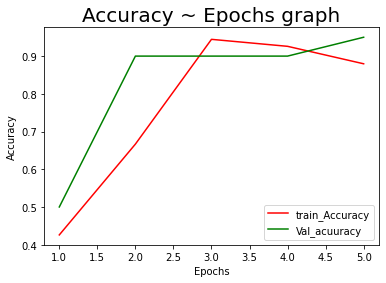

In [64]:
#Plot accuracy Chart
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
line1 = plt.plot(epochs, acc, label='train_Accuracy', color='red')
line2 = plt.plot(epochs, val_acc, label='Val_acuuracy',color='green')

plt.title('Accuracy ~ Epochs graph', fontsize=20)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.savefig('/content/drive/MyDrive/datasets/covid19/accuracy-epochs2.png')
plt.legend()
plt.show()

        Epochs ~ accuracy graph

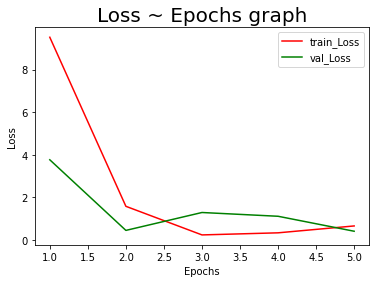

In [65]:
#Plot accuracy Chart
history_dict = history.history

acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
line1 = plt.plot(epochs, acc, color ='red', label ='train_Loss')
line2 = plt.plot(epochs, val_acc, color='green', label = 'val_Loss')

plt.title('Loss ~ Epochs graph',fontsize=20)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/datasets/covid19/loss-epochs2.png')
plt.legend()
plt.show()

        #      Confusion matix




In [66]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [5]:
import tensorflow as tf
classifier = tf.keras.models.load_model('/content/drive/MyDrive/datasets/covid19/covid1.h5')

Confusion matrix 
 [[6 4]
 [3 7]]


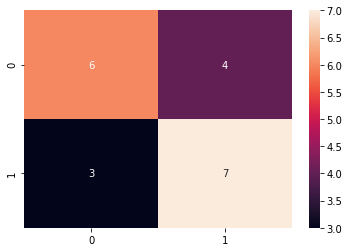

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt


y_pred =classifier.predict(validation_generator)
y_pred=np.argmax(y_pred, axis=1)

confusion= confusion_matrix(validation_generator.classes, y_pred)
print('Confusion matrix \n', confusion)

sn.heatmap(confusion, annot=True)
plt.savefig('/content/drive/MyDrive/datasets/covid19/confusion_matrix2.png')
plt.show()
